In [511]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# set preferred seaborn style
sns.set(style="darkgrid")
# make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

print(f"numpy v{np.__version__}")
print(f"matplotlib v{mpl.__version__}")
print(f"pandas v{pd.__version__}")
print(f"seaborn v{sns.__version__}")
print(f"sklearn v{skl.__version__}")

numpy v1.19.2
matplotlib v3.3.2
pandas v1.2.1
seaborn v0.11.1
sklearn v0.23.2


# What Should I List My Used Car For? #
*Author: D. McGlinchey*

I came across a dataset on [kaggle](https://www.kaggle.com/austinreese/craigslist-carstrucks-data) from user Austin Reese containing scraped data from Craigslist on car sale posts. I thought it would be interesting to use this data to estimate how much my car could be worth if I listed it for private sale (not that I want to sell it!).

I have a 2013 Subaru Impreza WRX hatch in WR Blue Pearl with approximately 111,000 miles on the odometer. It's in pretty good condition and is a great car. It's fun to drive, and is a blast in the Rocky Mountains.

If I look on [Kelly Blue Book](kbb.com), the private party estimate is 11,932 with a range from 10,357 to 13,506. What does this dataset predict?

![My WRX](my_wrx.png "My 2013 Subaru WRX")

In [237]:
my_car = {'make': 'subaru', 
          'model': 'wrx', 
          'year': 2013, 
          'odometer': 111000, 
          'color': 'blue', 
          'state': 'co',
          'transmission': 'manual',
          'condition': 'good',
          'region': 'Rocky Mountain'}
lp_kbb = 11.932

## The Data ##

The data comes from kaggle user Austin Reese as the ``[Used Cars Dataset - Vehicles listings from Craigslist.org](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)``. It contains scraped data from all Craigslist car listings over a few month period. 

Our first task is to clean up and simplify the dataset for our purposes. Then we'll explore what remains in order to get a feel for what the dataset can and can not help us with. Following that we'll take deeper dives into Subaru's, and in particular the WRX model, and see what we can learn from the dataset alone.

### Data cleanup ###

As always, we should start by reading in the dataset, and answering the first big questions for an unfamiliar dataset (if they aren't already known):
- What information is stored?
- What size is it?
- How complete is it?

We can't do any of that until it's loaded, so start there. 

In [3]:
df_orig = pd.read_csv('vehicles.csv')

In [4]:
df = df_orig.copy()
df.shape

(458213, 26)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [6]:
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


Okay, we've now started to answer our initial questions. We've got a respectable number of entries at >450k, which should give us some statistically significant findings. There's also a lot of good information for each entry that can help hone our understanding of what's driving the listing price. 

While there's a lot of good information here, there is also a bunch of information that is less interesting for our purposes. Let's simplify the dataset, dropping some columns we won't need.

In [7]:
df.drop(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'image_url', 'VIN', 'size'], axis=1, inplace=True)

Okay. Now that we're starting to narrow in, how complete is the dataset (i.e. how much cleaning up are we going to need to do)?

In [8]:
df.isna().sum()

price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
odometer         55303
title_status      2577
transmission      2442
drive           134188
type            112738
paint_color     140843
description         70
state                0
lat               7448
long              7448
posting_date        28
dtype: int64

That's a lot of `NaN`. For now, let's simply drop rows with `NaN`'s in columns that are the most important. Namely `manufacturer`, `model`, `year`, `price`, `state`, and `posting_date`.

In [9]:
df.dropna(subset=['year', 'manufacturer', 'model', 'price', 'state', 'posting_date'], inplace=True)
df.shape

(435178, 18)

Now let's manipulate the dataframe a bit to make it easier to work with. First, simplify some names and convert the posting time into a `datetime` object. Also add a column with the ISO week number. Since we know the dataset only spans a few months at most, week may be a better aggregation tool.

In [10]:
df.rename({'manufacturer': 'make', 'paint_color': 'color', 'title_status': 'title'}, axis=1, inplace=True)

In [11]:
df['post_datetime'] = pd.to_datetime(df['posting_date'].apply(lambda dt: str(dt).split('T')[0]), errors='coerce')

In [12]:
df['post_week'] = df['post_datetime'].dt.isocalendar().week
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435178 entries, 0 to 458211
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   price          435178 non-null  int64         
 1   year           435178 non-null  float64       
 2   make           435178 non-null  object        
 3   model          435178 non-null  object        
 4   condition      252703 non-null  object        
 5   cylinders      275155 non-null  object        
 6   fuel           432299 non-null  object        
 7   odometer       386469 non-null  float64       
 8   title          432999 non-null  object        
 9   transmission   432985 non-null  object        
 10  drive          311927 non-null  object        
 11  type           332648 non-null  object        
 12  color          304225 non-null  object        
 13  description    435136 non-null  object        
 14  state          435178 non-null  object        
 15  

It will also be more useful to have the year column as an integer rather than a float. Fix that, than also add an age column for easy selection later

In [13]:
df['year'] = df['year'].astype('int')
df['age'] = 2021 - df['year']
df.dtypes

price                     int64
year                      int64
make                     object
model                    object
condition                object
cylinders                object
fuel                     object
odometer                float64
title                    object
transmission             object
drive                    object
type                     object
color                    object
description              object
state                    object
lat                     float64
long                    float64
posting_date             object
post_datetime    datetime64[ns]
post_week                UInt32
age                       int64
dtype: object

We can also normalize some of our columns. We know prices will generally be in the thousands of dollars.

In [14]:
df['price'] = df['price'] / 1e3

It would also be nice to be able to aggregate by region of the US, rather than at the state level. For this let's consider the regions as used by the [Bureau of Econmic analysis](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States#Census_Bureau-designated_regions_and_divisions):
- **New England**: Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island and Vermont
- **Mideast**: Delaware, District of Columbia, Maryland, New Jersey, New York and Pennsylvania
- **Great Lakes**: Illinois, Indiana, Michigan, Ohio and Wisconsin
- **Plains**: Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota and South Dakota
- **Southeast**: Alabama, Arkansas, Florida, Georgia, Kentucky, Louisiana, Mississippi, North Carolina, South Carolina, Tennessee, Virginia and West Virginia
- **Southwest**: Arizona, New Mexico, Oklahoma and Texas
- **Rocky Mountain**: Colorado, Idaho, Montana, Utah and Wyoming
- **Far West**: Alaska, California, Hawaii, Nevada, Oregon and Washington

In [15]:
regions_to_states = {'New England': ['ct', 'me', 'ma', 'nh', 'ri', 'vt'],
                     'Mideast': ['de', 'dc', 'md', 'nj', 'ny', 'pa'],
                     'Great Lakes': ['il', 'in', 'mi', 'oh', 'wi'],
                     'Plains': ['ia', 'ks', 'mn', 'mo', 'ne', 'nd', 'sd'],
                     'Southeast': ['al', 'ar', 'fl', 'ga', 'ky', 'la', 'ms', 'nc', 'sc', 'tn', 'va', 'wv'],
                     'Southwest': ['az', 'nm', 'ok', 'tx'],
                     'Rocky Mountain': ['co', 'id', 'mt', 'ut', 'wy'], 
                     'Far West': ['ak', 'ca', 'hi', 'nv', 'or', 'wa']}
print(f"N regions: {len(regions_to_states)}")
n_states = 0
states_to_region = {}
for region, lst in regions_to_states.items():
#     print(f"Region: {region} [{len(lst)}]: {lst}")
    n_states += len(lst)
    for state in lst:
        states_to_region[state] = region
print(f"N states: {n_states}")
# print(f"len(states_to_region): {len(states_to_region)}")
# print(states_to_region)

N regions: 8
N states: 51


In [16]:
df['region'] = df.apply(lambda row: states_to_region[row.state], axis=1)

Better. Now it's time to explore the dataset a bit.

Text(30000, 5, 'My car')

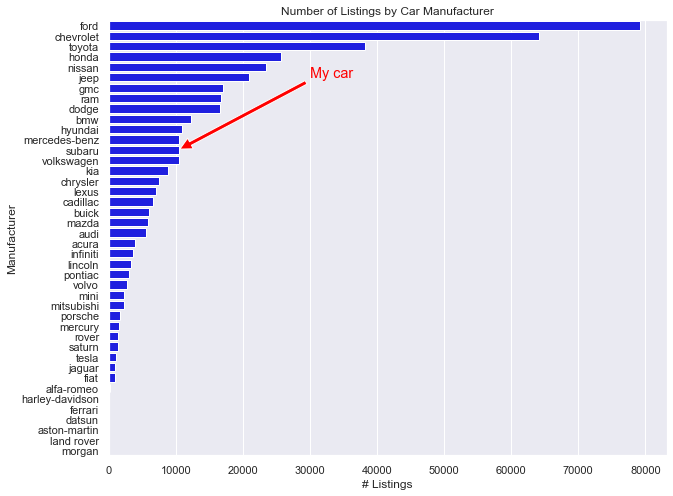

In [17]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(y="make", data=df, color='blue', order=df.make.value_counts().index)
ax.set_title('Number of Listings by Car Manufacturer')
ax.set_ylabel('Manufacturer')
ax.set_xlabel('# Listings')
ax.annotate("My car",
            xy=(df.make.value_counts()[my_car['make']], df.make.value_counts().index.get_loc(my_car['make'])),
            xytext=(30000,5),
            arrowprops=dict(facecolor='red', shrink=0.01), color='red', fontsize='large')

Text(30000, 8, 'My car')

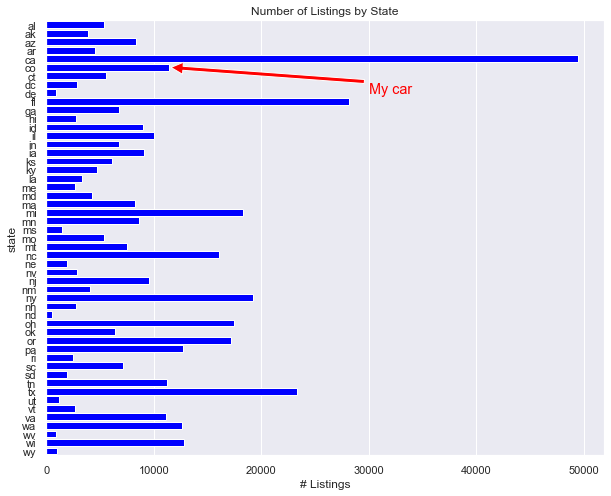

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(y='state', data=df, facecolor='blue')
ax.set_title('Number of Listings by State')
ax.set_xlabel('# Listings')
ax.annotate("My car",
            xy=(df.state.value_counts().loc[my_car['state']], np.where(df.state.unique() == my_car['state'])[0][0]),
            xytext=(30000,8),
            arrowprops=dict(facecolor='red', shrink=0.01), color='red', fontsize='large')

Text(13, 41724, 'My car')

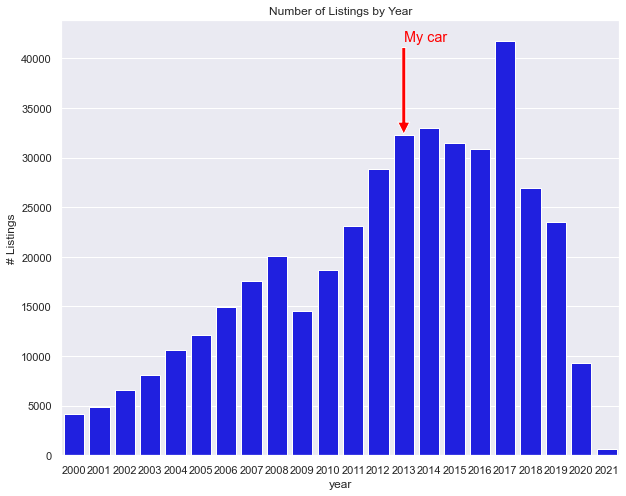

In [19]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(x='year', data=df[df['year']>=2000], color='blue')
# plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_title('Number of Listings by Year')
ax.set_ylabel('# Listings')
ax.annotate("My car",
            xy=(my_car['year'] - 2000, df.year.value_counts().loc[my_car['year']]),
            xytext=(my_car['year'] - 2000,df.year.value_counts().max()),
            arrowprops=dict(facecolor='red', shrink=0.01), color='red', fontsize='large')

In [20]:
print(f"Earliest listing: {df.post_datetime.min()}")
print(f"Latest listing:   {df.post_datetime.max()}")

Earliest listing: 2020-10-22 00:00:00
Latest listing:   2020-12-03 00:00:00


Text(0.5, 0, 'ISO Week Number')

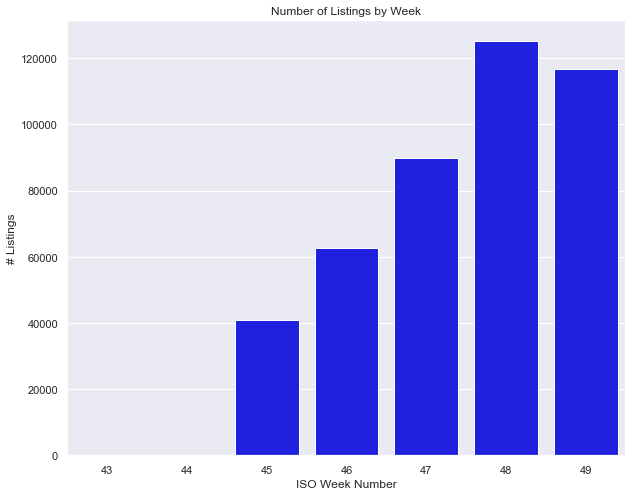

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(x='post_week', data=df, color='blue')
ax.set_title('Number of Listings by Week')
ax.set_ylabel('# Listings')
ax.set_xlabel('ISO Week Number')

This gives us a good overview of the dataset and it's potential. But, for a little diversion, let's take a deeper dive into Subaru's, my favorite manufacturer.


### Subaru ###

Start by making a dataframe that contains only Subaru postings so that we have a smaller dataset to work with.

In [22]:
df_subaru = df[df['make'] == 'subaru']
df_subaru.shape

(10430, 22)

The `model` values are going to be all over the place, so we'll first need to simplify them.

In [23]:
subaru_models = ['sti', 'wrx', 'impreza', 'outback', 'forester', 'crosstrek', 'brz', 'legacy', 'ascent', 'tribeca']

In [24]:
for m in subaru_models:
    df_subaru.loc[df_subaru.model.str.contains(m), 'model'] = m

/Users/darrenmcglinchey/opt/anaconda3/envs/cars/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [25]:
df_subaru = df_subaru[df_subaru['model'].isin(subaru_models)]

In [26]:
df_subaru.model.unique()

array(['outback', 'impreza', 'legacy', 'sti', 'forester', 'wrx', 'brz',
       'crosstrek', 'tribeca', 'ascent'], dtype=object)

In [27]:
df_subaru.shape

(10320, 22)

Good. Now we've made the `model` feature useful to us. Let's see what we've got.

Text(1200, 5, 'My car')

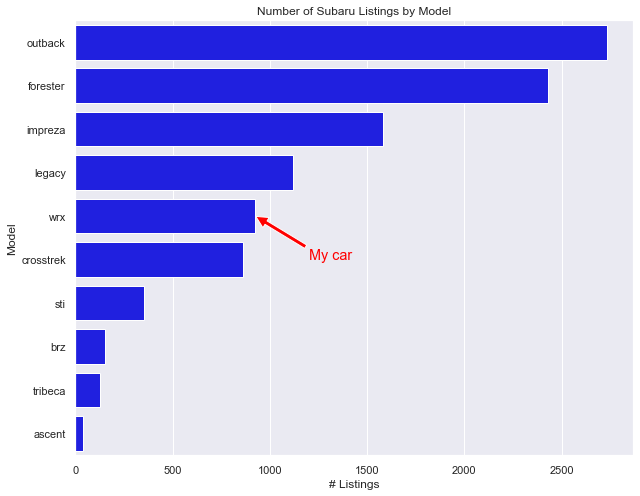

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(y="model", data=df_subaru, color='blue', order=df_subaru.model.value_counts().index)
ax.set_title('Number of Subaru Listings by Model')
ax.set_ylabel('Model')
ax.set_xlabel('# Listings')
ax.annotate("My car",
            xy=(df_subaru.model.value_counts()[my_car['model']], 
                df_subaru.model.value_counts().index.get_loc(my_car['model'])),
            xytext=(1200,5),
            arrowprops=dict(facecolor='red', shrink=0.01), color='red', fontsize='large')

Text(0.5, 0, '# Listings')

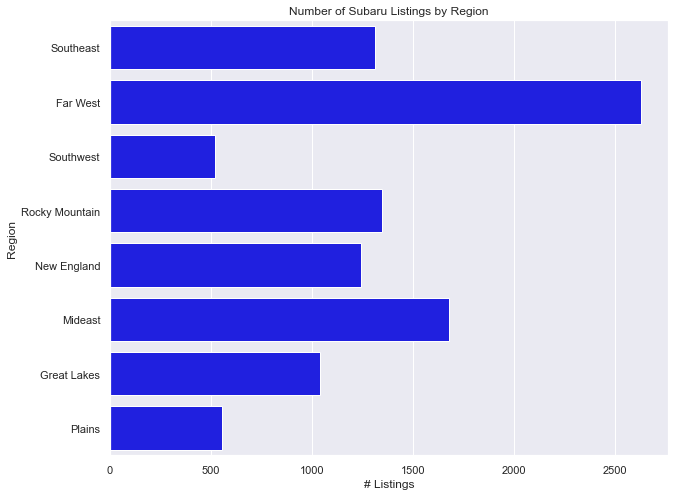

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(y="region", data=df_subaru, color='blue')
ax.set_title('Number of Subaru Listings by Region')
ax.set_ylabel('Region')
ax.set_xlabel('# Listings')
# ax.annotate("My car",
#             xy=(df_subaru.model.value_counts()[my_car['model']], 
#                 df_subaru.model.value_counts().index.get_loc(my_car['model'])),
#             xytext=(1200,5),
#             arrowprops=dict(facecolor='red', shrink=0.01), color='red', fontsize='large')

Text(0.5, 0, 'Subaru Model')

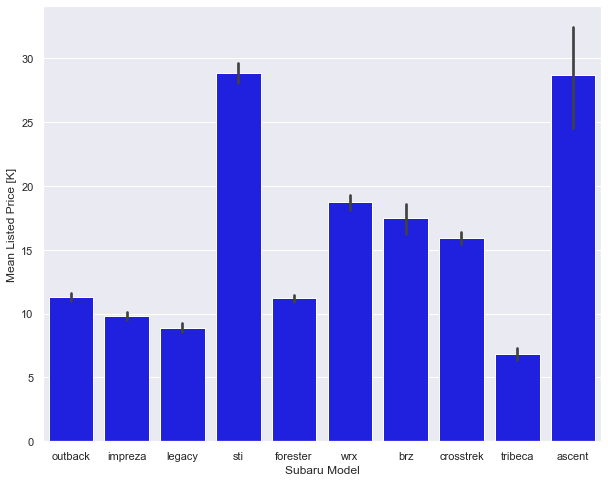

In [30]:
fig = plt.figure(figsize=(10, 8))
ax = sns.barplot(x='model', y='price', data=df_subaru, color='blue')
ax.set_ylabel('Mean Listed Price [K]')
ax.set_xlabel('Subaru Model')

The results look pretty reasonable. The Subaru STi is the top of the line performance model, and the Ascent is their newest model, so we would probably expect them to have the highest average list price. The Outback and Forester are also Subaru's most popular models, and so it's not surprising that they make up the bulk of the listings. 

### The Subaru WRX ###

Now let's drill down further and focus on the Subaru WRX model. For this, we'll be considering the WRX base only and excluding the STi. Obviously, the WRX is the best, since I own one. This simplification will also help us keep things more consistent, as there is a significant price difference between base model WRX's and the more powerful WRX STi. 

As before, start by subsetting the dataset and then exploring it.

In [152]:
df_wrx = df_subaru[df_subaru['model'] == 'wrx']
df_wrx.shape

(925, 22)

Let's start off by looking at the listing prices. We'll choose the make a scatterplot vs the odemeter reading to get a feel for things.

Text(0, 0.5, 'Odometer Reading [miles]')

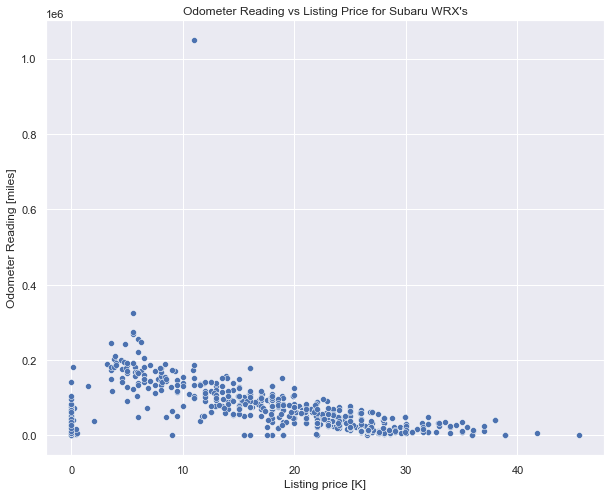

In [153]:
fig = plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='price', y='odometer', data=df_wrx)
ax.set_title("Odometer Reading vs Listing Price for Subaru WRX's")
ax.set_xlabel('Listing price [K]')
ax.set_ylabel('Odometer Reading [miles]')

Hmm. There's definitly some odd listings here. Someone is claiming to have driven over a million miles. That seems unlikely. Also there are a lot of listings grouped down at 0 dollars. Let's take a quick look at a sample of those:

In [154]:
df_wrx[df_wrx.price == 0].sample(10)

,price,year,make,model,condition,cylinders,fuel,odometer,title,transmission,...,color,description,state,lat,long,posting_date,post_datetime,post_week,age,region
182566,0.0,2017,subaru,wrx,NaN,NaN,gas,67996.0,clean,manual,...,black,2017 Subaru WRX STI Limited AWD STI Limited 4d...,md,38.633440,-76.904090,2020-11-14T13:41:03-0500,2020-11-14,46,4,Mideast
418577,0.0,2018,subaru,wrx,NaN,NaN,gas,34885.0,clean,manual,...,silver,2018 Subaru WRX Limited AWD **Two Owner Clean ...,wa,47.839605,-122.302203,2020-12-01T16:32:06-0800,2020-12-01,49,3,Far West
185247,0.0,2013,subaru,wrx,like new,4 cylinders,gas,120.0,clean,manual,...,black,"534 River Street Haverhill, MA (978)914-7034....",ma,42.779200,-71.109500,2020-11-27T07:47:45-0500,2020-11-27,48,8,New England
404370,0.0,2020,subaru,wrx,NaN,4 cylinders,gas,6170.0,clean,manual,...,blue,"2020 Subaru WRX TURBO AWD, FULL FACTORY WARRAN...",va,36.904580,-76.133600,2020-11-14T11:39:18-0500,2020-11-14,46,1,Southeast
126337,0.0,2017,subaru,wrx,NaN,NaN,gas,NaN,clean,manual,...,NaN,Rear Defroster Auxiliary and USB Input Cruise ...,id,43.632200,-116.205200,2020-11-29T10:14:19-0700,2020-11-29,48,4,Rocky Mountain
73628,0.0,2015,subaru,wrx,NaN,NaN,gas,0.0,clean,manual,...,blue,Greeley Subaru address: 4720 W 24th St Gree...,co,40.398459,-104.757364,2020-11-20T07:40:15-0700,2020-11-20,47,6,Rocky Mountain
417027,0.0,2017,subaru,wrx,NaN,4 cylinders,gas,27387.0,clean,manual,...,NaN,Titus-Will Chevrolet STOCK #: NG7746 ...,wa,47.157009,-122.434148,2020-12-02T13:52:55-0800,2020-12-02,49,4,Far West
12333,0.0,2018,subaru,wrx,NaN,NaN,gas,40933.0,clean,automatic,...,NaN,Used 2018 Subaru WRX STi Welcome to Right ...,az,33.633522,-111.914160,2020-12-01T15:21:16-0700,2020-12-01,49,3,Southwest
184152,0.0,2013,subaru,wrx,like new,4 cylinders,gas,120.0,clean,manual,...,black,"534 River Street Haverhill, MA (978)914-7034....",ma,42.779200,-71.109500,2020-11-30T08:07:31-0500,2020-11-30,49,8,New England
335812,0.0,2017,subaru,wrx,NaN,NaN,gas,67996.0,clean,manual,...,black,2017 Subaru WRX STI Limited AWD STI Limited 4d...,pa,38.633440,-76.904090,2020-11-14T14:40:59-0500,2020-11-14,46,4,Mideast


Nothing is obviously wrong other than the price, but that will definitly throw us off later. For now, let's simplify things by dropping those rows, along with the high-milage row. I'll even cheat a little and throw out any listings below $1,000 under the assumption that those listings indicate some further issue with the vehicle (or scraping). Don't forget that we've already normalized the price to thousands!

In [155]:
df_wrx = df_wrx[df_wrx.price > 1]
df_wrx = df_wrx[df_wrx.odometer < 500000]
df_wrx.shape

(795, 22)

Before we dive in to the analysis, we probably need to do some cleanup on the other categories as well.

In [156]:
df_wrx.isna().sum()

price              0
year               0
make               0
model              0
condition        292
cylinders        403
fuel               1
odometer           0
title              9
transmission       3
drive            402
type             106
color            157
description        0
state              0
lat                4
long               4
posting_date       0
post_datetime      0
post_week          0
age                0
region             0
dtype: int64

Note the large number of `NaN` in the `condition`, `type`, and `color` categories. We'll make sure we're paying attention to that as we're cleaning up.

In [157]:
df_wrx.condition.value_counts()

good         302
excellent    148
like new      37
fair          10
new            4
salvage        2
Name: condition, dtype: int64

To make things simpler, let's drop `fair` and `salvage`. For my interest, I'm looking for good to like-new condition. Since we had a lot of `NaN` here, let's assume those are `good` rather than dropping them all.

In [158]:
df_wrx.fillna(value={'condition': 'good'}, inplace=True)
df_wrx = df_wrx[df_wrx['condition'].isin(['good', 'excellent', 'like new', 'new'])]
df_wrx.condition.value_counts()

good         594
excellent    148
like new      37
new            4
Name: condition, dtype: int64

In [159]:
df_wrx.transmission.value_counts()

manual       494
other        210
automatic     76
Name: transmission, dtype: int64

Boy, that's a lot of `other`. Subaru's only come as either `manual` or `automatic`, with `manual` much more likely. Let's be bold and assume all `other` are `manual`, and do the same for the few `NaN` values.

In [160]:
df_wrx.fillna(value={'transmission': 'manual'}, inplace=True)
df_wrx.loc[df_wrx['transmission'] == 'other', 'transmission'] = 'manual'
df_wrx.transmission.value_counts()

manual       707
automatic     76
Name: transmission, dtype: int64

In [161]:
df_wrx.type.value_counts()

sedan        563
wagon         66
hatchback     27
other         17
coupe          6
Name: type, dtype: int64

The WRX's we're interested in are only `sedan` or `hatchback`/`wagon`. We should drop the others and combine `wagon` with `hatchback`, but what to do about the `NaN`? Let's go ahead and drop/combine, and then maybe we can use the `year` to make an educated guess.

In [166]:
df_wrx.loc[df_wrx['type'] == 'wagon', 'type'] = 'hatchback'
df_wrx = df_wrx[df_wrx['type'] != 'coupe']

<AxesSubplot:xlabel='count', ylabel='year'>

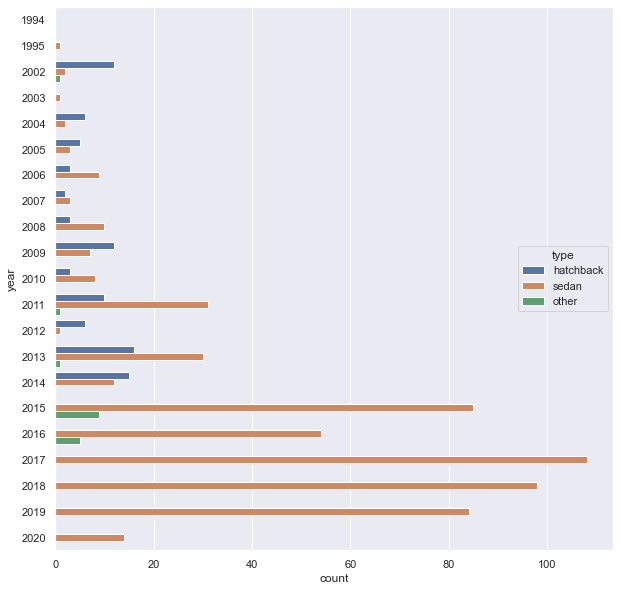

In [167]:
fig = plt.figure(figsize=(10, 10))
sns.countplot(y='year', hue='type', data=df_wrx)

Okay, this is useful. The `other` should be `sedan`, since WRX's only come as sedan's in the current generation. Where do the `NaN`'s actually fall?

<AxesSubplot:xlabel='count', ylabel='year'>

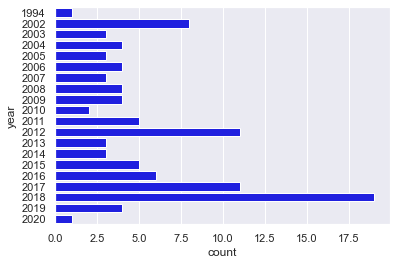

In [169]:
sns.countplot(y='year', data=df_wrx[df_wrx['type'].isna()], color='blue')

In [171]:
df_wrx.loc[df_wrx['year'] > 2014, 'type'] = 'sedan'
df_wrx['type'].isna().sum()

58

We still have 58 remaining `NaN` values and 3 `other`. We could probably do a better job of salvaging them if we looked at the description, but for now it'll be easier to simply drop them.

In [173]:
df_wrx = df_wrx[df_wrx['type'].isin(['sedan', 'hatchback'])]
df_wrx.type.value_counts()

sedan        623
hatchback     93
Name: type, dtype: int64

In [174]:
df_wrx.title.value_counts()

clean      670
rebuilt     24
lien        10
salvage      3
Name: title, dtype: int64

Same thing here. Let's only worry about `clean` titles.

In [175]:
df_wrx = df_wrx[df_wrx['title'] == 'clean']
df_wrx.title.value_counts()

clean    670
Name: title, dtype: int64

In [176]:
df_wrx.color.value_counts()

blue      174
white      94
silver     80
black      78
red        67
grey       46
custom      8
green       2
brown       1
Name: color, dtype: int64

In [177]:
df_wrx.color.isna().sum()

120

I don't believe `brown` or `green` were ever valid colors offered at dealerships. Let's combine those, `custom` and `NaN` values into a single category of `other`

In [178]:
df_wrx.loc[~df.color.isin(['blue', 'white', 'silver', 'black', 'red', 'grey']), 'color'] = 'other'
df_wrx.color.value_counts()

blue      174
other     131
white      94
silver     80
black      78
red        67
grey       46
Name: color, dtype: int64

In [179]:
df_wrx.shape

(670, 22)

In [187]:
df_wrx.isna().sum()

price              0
year               0
make               0
model              0
condition          0
cylinders        354
fuel               1
odometer           0
title              0
transmission       0
drive            355
type               0
color              0
description        0
state              0
lat                3
long               3
posting_date       0
post_datetime      0
post_week          0
age                0
region             0
gen                0
dtype: int64

All told, we've dropped about 250 listings, but that should make our findings more robust and easier to deal with. 

What are the popular model years?

Text(0, 0.5, '# Listings')

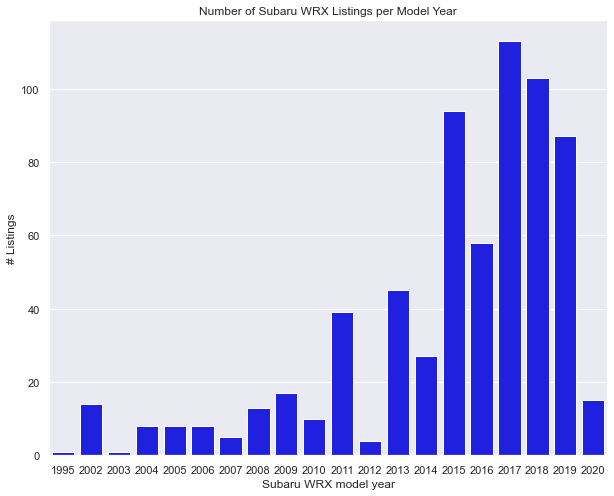

In [180]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(x='year', data=df_wrx, color='blue')
ax.set_title('Number of Subaru WRX Listings per Model Year')
ax.set_xlabel('Subaru WRX model year')
ax.set_ylabel('# Listings')

Hmm. Okay, that doesn't look bad, but we're starting to deal with limited listings. Since most of the time, there aren't significant changes year-to-year, let's add a new column that corresponds to the 'generation' of the model. WRX's are generally considered to have 4 generations. They are:
- 1st generation (1992 - 2000): Subaru didn't make the first generation available in the US, but imports are generally highly desirable for their stripped down nature.
- 2nd generation (2000 - 2007): Subaru finally brought the WRX to the US in 2002, and this generation saw two facelifts during it's cycle giving us the "bug eye", "blob eye", and "hawk eye" versions. Throughout this generation the WRX was available as both a sedan as well as a wagon variant. We'll consider all of them as the same generation for this purpose
- 3rd generation (2007 - 2014): A significant redesign for the WRX, initially available as a hatchback only. The initial version was panned as being bland, and they added the STi's wide body kit to the base WRX midway though the generation, and then dropped the hatchback for a sedan towards the end of the lifecycle. All of the different variants in the generation have different desirability in enthusiest circles, but again for now we'll consider all of them as a single generation.
- 4th generation (2014 - present): A full redisgn that dropped the Impreza name and moved to sedan only. The engine was also moved from a 2.4L coupled to a 5-speed to a 2.0L coupled to a 6-speed

There are clearly a few 1st gen listings, probably imports, in the dataset. For this investigation, we don't really care about those, so we'll only consider the 2nd-4th generations and drop everything else.

In [181]:
def wrx_generation(year):
    if 2000<=year<2007:
        return 2
    elif 2007<=year<2014:
        return 3
    elif 2014<=year<=2020:
        return 4
    else:
        return np.nan

In [182]:
df_wrx['gen'] = df_wrx.apply(lambda row: wrx_generation(row.year), axis=1)

In [183]:
df_wrx.dropna(subset=['gen'], inplace=True)
df_wrx.shape

(669, 23)

Text(0, 0.5, '# Listings')

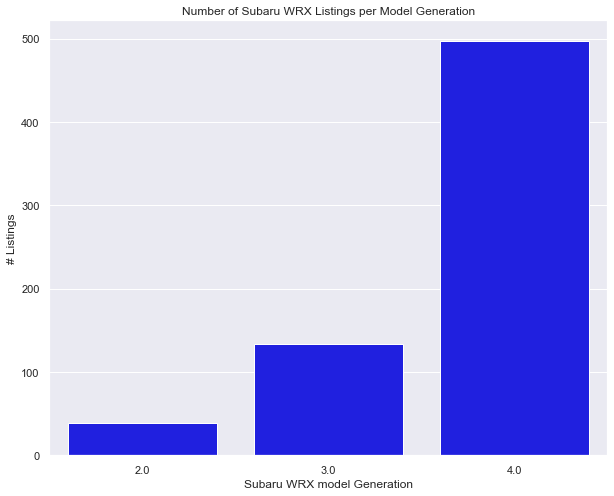

In [184]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(x='gen', data=df_wrx, color='blue')
ax.set_title('Number of Subaru WRX Listings per Model Generation')
ax.set_xlabel('Subaru WRX model Generation')
ax.set_ylabel('# Listings')

Better. As we can see, there are many more listings for the current generation than the older generations. This makes sense, the 3rd generation is already over 6 years old. 

Let's now turn to the price distribution conditioned on the model generation. While we're at it, let's also condition on the region to see if we need to consider those variations. We can do this using a Kernal Density Estimate (KDE) plot that estimates the continuous probability density distribution, here vs the listing price.

/Users/darrenmcglinchey/opt/anaconda3/envs/cars/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


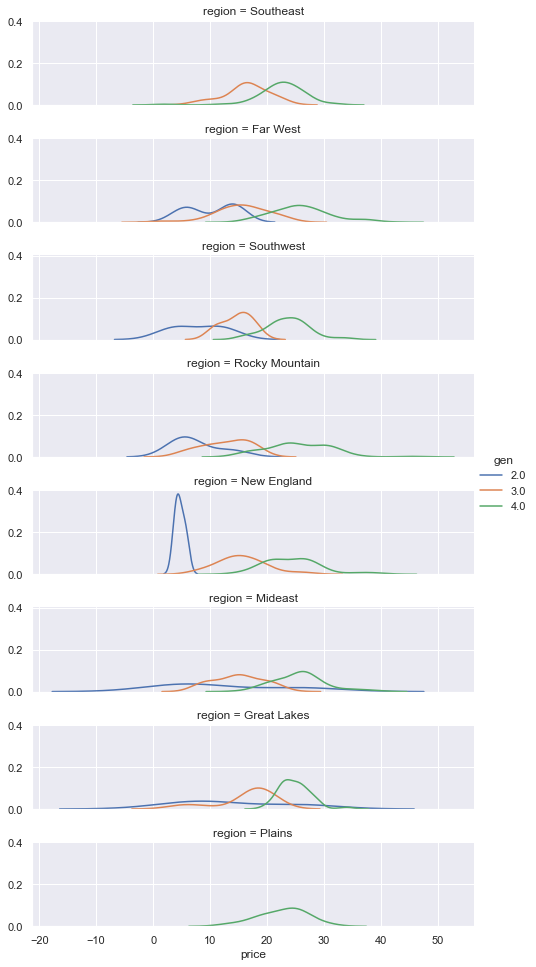

In [185]:
g = sns.FacetGrid(df_wrx, row='region', height=1.7, aspect=4, hue='gen')
g.map(sns.kdeplot, 'price')
g.add_legend()

The distributions certainly vary with region, but not by a huge amount. We can get another view of that by using a violin plot. Here we'll focus on the 3rd generation (because it's the best!).

Text(0.5, 0, 'Listing Region')

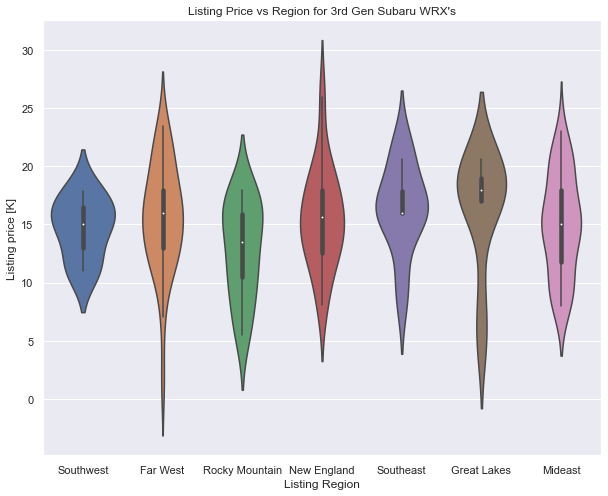

In [188]:
fig = plt.figure(figsize=(10, 8))
ax = sns.violinplot(x='region', y='price', data=df_wrx[df_wrx.gen == 3])
ax.set_title("Listing Price vs Region for 3rd Gen Subaru WRX's")
ax.set_ylabel('Listing price [K]')
ax.set_xlabel('Listing Region')

There is definitly variation in the distribution of listing price across regions, with the means varying by maybe 5K. It'll remain unclear from this dataset what is driving that difference. It could be simply demand, something like relative salt damage in the winter months, prevelance of winter weather (AWD for the win!), or variations in income across the US. But don't forget, there are also many other variables that go into the price that may or may not be consistent across the regions, like the milage, model year within the generation, transmission, etc. 

Speaking of milage, lets plot the updated distribution of odometer reading vs price, conditioned on generation. Once again we'll use a scatter plot to visualize the distributions.

Text(0, 0.5, 'Odometer Reading [miles]')

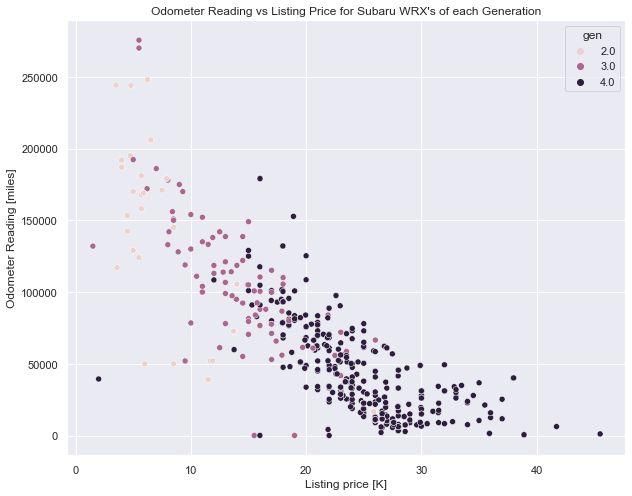

In [189]:
fig = plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='price', y='odometer', hue='gen', data=df_wrx)
# ax.set_ylim([0, 200000])
ax.set_title("Odometer Reading vs Listing Price for Subaru WRX's of each Generation")
ax.set_xlabel('Listing price [K]')
ax.set_ylabel('Odometer Reading [miles]')

Interesting. One might have hypothosized that certain generations are more or less desirable based on their performance characteristics and/or looks. This certainly doesn't make a good case for that idea, as each generation appears to smoothly blend into the other. Let's do the same thing, but this time looking at the age of the vehicle.

Text(0, 0.5, 'Age [years]')

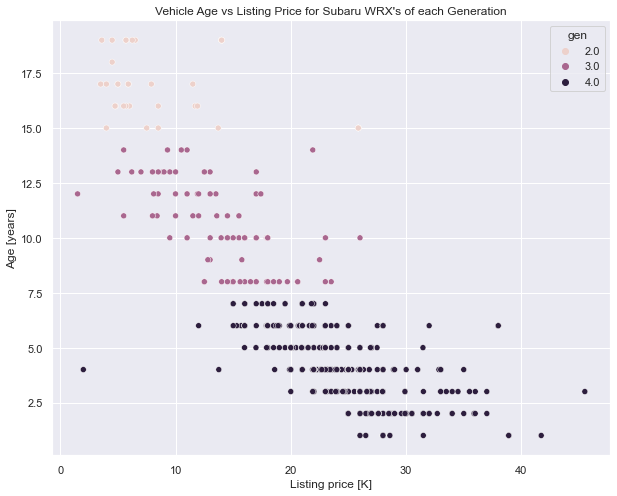

In [190]:
fig = plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='price', y='age', hue='gen', data=df_wrx)
# ax.set_ylim([0, 200000])
ax.set_title("Vehicle Age vs Listing Price for Subaru WRX's of each Generation")
ax.set_xlabel('Listing price [K]')
ax.set_ylabel('Age [years]')

Yup. It certainly doesn't appear like generation is playing a significant factor here. There's a pretty smooth transition between generations given the distributions we're working with. Honestly, I'm a little surprised, but maybe that's just the enthusiest in me. 

We've looked at a few factors individually, but let's more systematically investigate how different factors effect the listing price.

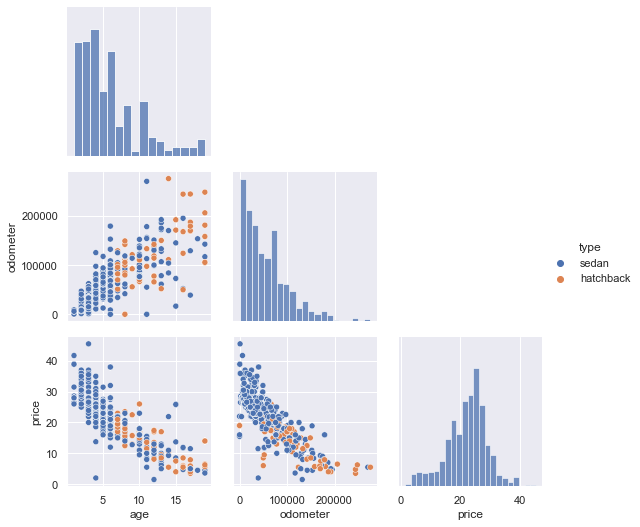

In [199]:
variables = ['age', 'odometer', 'price']
g = sns.PairGrid(df_wrx, vars=variables, hue='type', dropna=True, corner=True)
g.map_diag(sns.histplot, hue=None)
g.map_lower(sns.scatterplot)
# g.map_upper(sns.regplot, line_kws={'color': 'red'})
g.add_legend()

Let's also look at the categorical values. For most of these we'll plot `type` (body stype) side by side. Age is a huge factor in the price, and the type is a simple categorical value that is a proxy for age.

Text(0.5, 0, 'Transmission Type')

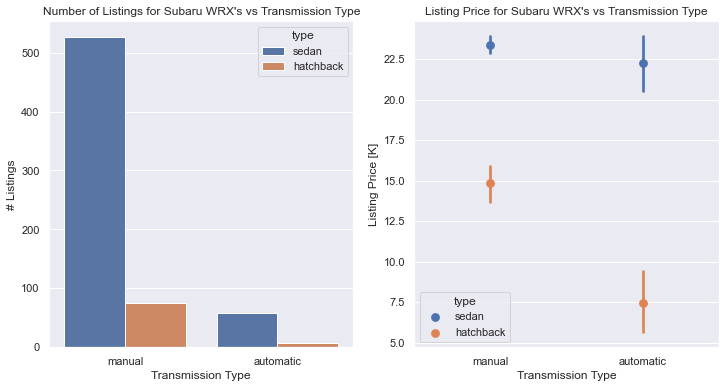

In [203]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(x='transmission', data=df_wrx, hue='type', ax=ax[0])
ax[0].set_title("Number of Listings for Subaru WRX's vs Transmission Type")
ax[0].set_xlabel("Transmission Type")
ax[0].set_ylabel("# Listings")

sns.pointplot(x='transmission', y='price', hue='type', data=df_wrx, linestyles=['', ''], ax=ax[1])
ax[1].set_title("Listing Price for Subaru WRX's vs Transmission Type")
ax[1].set_ylabel("Listing Price [K]")
ax[1].set_xlabel("Transmission Type")

Text(0.5, 0, 'Condition')

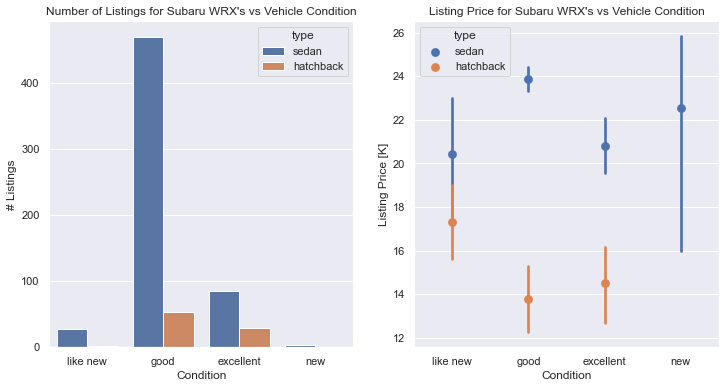

In [201]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(x='condition', hue='type', data=df_wrx, ax=ax[0])
ax[0].set_title("Number of Listings for Subaru WRX's vs Vehicle Condition")
ax[0].set_xlabel("Condition")
ax[0].set_ylabel("# Listings")

sns.pointplot(x='condition', y='price', hue='type', data=df_wrx, linestyles=['', ''], ax=ax[1])
ax[1].set_title("Listing Price for Subaru WRX's vs Vehicle Condition")
ax[1].set_ylabel("Listing Price [K]")
ax[1].set_xlabel("Condition")

Text(0.5, 0, 'Color')

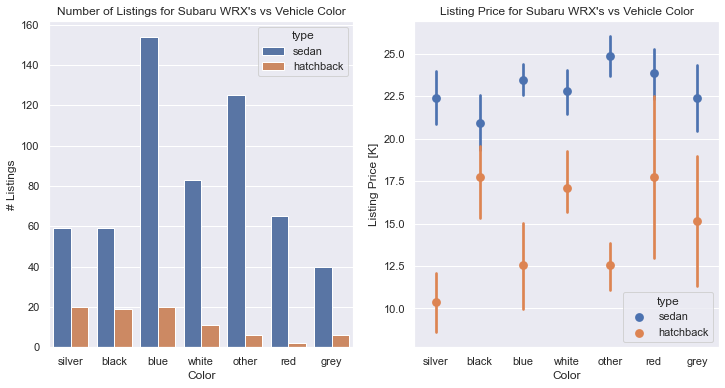

In [202]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(x='color', data=df_wrx, hue='type', ax=ax[0])
ax[0].set_title("Number of Listings for Subaru WRX's vs Vehicle Color")
ax[0].set_xlabel("Color")
ax[0].set_ylabel("# Listings")

sns.pointplot(x='color', y='price', hue='type', data=df_wrx, linestyles=['', ''], ax=ax[1])
ax[1].set_title("Listing Price for Subaru WRX's vs Vehicle Color")
ax[1].set_ylabel("Listing Price [K]")
ax[1].set_xlabel("Color")

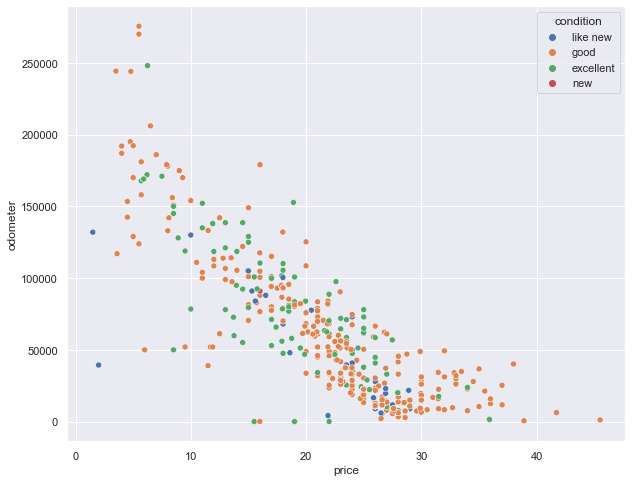

In [205]:
fig = plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='price', y='odometer', hue='condition', data=df_wrx)

We've explored and manipulated our dataset a bit. It's time to move on and try to estimate the listing price of my WRX.

## Simple Estimate of My List Price ##

To start off with, let's not do anything fancy. Let's get a baseline for what the list price should be for my WRX by looking at similar listings. We can use the WRX dataframe for this.

In [224]:
df_sim = df_wrx[df_wrx.year == my_car['year']]

In [225]:
# df_sim = df_sim[df_sim.region == my_car['region']]
df_sim = df_sim[df_sim.condition == my_car['condition']]
df_sim = df_sim[df_sim.transmission == my_car['transmission']]
# df_sim = df_sim[df_sim.odometer > 100000]
# df_sim = df_sim[df_sim.odometer < 120000]

In [226]:
df_sim.shape

(27, 23)

 R value: -0.9426231564456358
 P value: 2.0481354137001618e-13


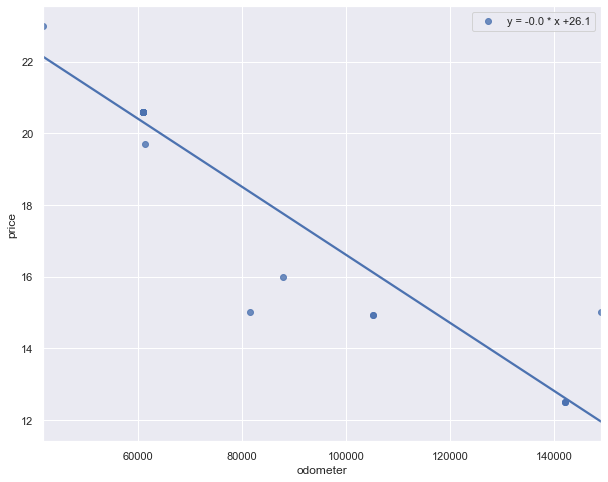

In [233]:
slope, intercept, r_value, p_value, se = stats.linregress(df_sim['odometer'], df_sim['price'])
fig = plt.figure(figsize=(10, 8))
ax = sns.regplot(y='price', x='odometer', data=df_sim,
                ci=None, label=f"y = {slope:.1f} * x {intercept:+.1f}")
ax.legend()
print(f" R value: {r_value}")
print(f" P value: {p_value}")

There we go. We can use this simple regression to give us a baseline list price:

In [236]:
lp_simple = slope * my_car['odometer'] + intercept
print(f"Simple List Price Estimate: ${lp_simple:.2f}K")

Simple List Price Estimate: $15.57K


## Estimating List Price Using ML ##

Okay, so that was a relatively simplistic estimate using listings with similar characteristic and assuming a single parameter regression. Can we do "better" with a more complicated model? Let's try using different supervised Machine Learning (ML) approaches.

Before throwing the data at our ML models, we'll first simplify and cleanup the data for use among all our approaches. Then we'll look at using progressively more complicated models using both scikit learn and keras.

### Cleaning up the ML dataset ###

To simplify our dataset, let's stick to models that are comparable or competitive with the Subaru WRX. We'll consider:
- Subaru WRX
- Ford Focus ST and RS
- Honda Civic Si
- Mitsubishi Lancer Ralliart
- Mazda MazdaSpeed3

In [401]:
def select_models(df):
    # drop any extra model info for those we care about
    df.loc[(df.make == 'ford') & (df.model.str.contains('focus rs')), 'model'] = 'focus rs'
    df.loc[(df.make == 'ford') & (df.model.str.contains('focus st')), 'model'] = 'focus st'
    df.loc[(df.make == 'honda') & (df.model.str.contains('civic si')), 'model'] = 'civic si'
    df.loc[(df.make == 'mitsubishi') & (df.model.str.contains('lancer ralliart')), 'model'] = 'lancer ralliart'
    df.loc[(df.make == 'mazda') & (df.model.str.contains('mazdaspeed3')), 'model'] = 'mazdaspeed3'
    df.loc[(df.make == 'subaru') & (df.model.str.contains('sti')), 'model'] = 'sti'
    df.loc[(df.make == 'subaru') & (df.model.str.contains('wrx')), 'model'] = 'wrx'
    # select only models of interest
    df = df[(df.make.isin(['ford', 'honda', 'mitsubishi', 'subaru'])) &
            (df.model.isin(['focus rs', 'focus st', 'civic si', 'lancer ralliart', 
                            'mazdaspeed3', 'wrx']))]
    return df

In [574]:
df_ml = select_models(df.copy())
df_ml.shape

(1379, 22)

Let's also cleanup this dataset by dropping columns we don't need, cleaning up `NaN`'s, and removing bogus entries.

In [575]:
def reg_cleanup(df):
    # drop unnecessary columns
    df.drop(['year', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 
             'description', 'state', 'lat', 'long', 
             'posting_date', 'post_datetime', 'post_week'], axis=1 , inplace=True)
    df.fillna(value={'condition': 'good', 'cylinders': 4, 'title': 'clean'}, inplace=True)
    df.dropna(subset=['odometer', 'color'], inplace=True)
    df = df[df['odometer'] < 1e6]
    df = df[df['price'] > 1]
    df.loc[df.color.isin(['green', 'orange', 'brown']), 'color'] = 'custom'
    return df

In [576]:
df_ml = reg_cleanup(df_ml)
df_ml.shape

(961, 9)

In [577]:
df_ml.color.value_counts()

blue      253
black     177
white     159
silver    155
red       108
grey       81
custom     18
yellow     10
Name: color, dtype: int64

In [578]:
df_ml.isna().sum()

price        0
make         0
model        0
condition    0
odometer     0
title        0
color        0
age          0
region       0
dtype: int64

In [579]:
df_ml.model.value_counts()

wrx                638
civic si           193
focus st           117
focus rs             8
lancer ralliart      5
Name: model, dtype: int64

Text(0.5, 1.0, 'Odometer Milage vs Listing Price for different Models')

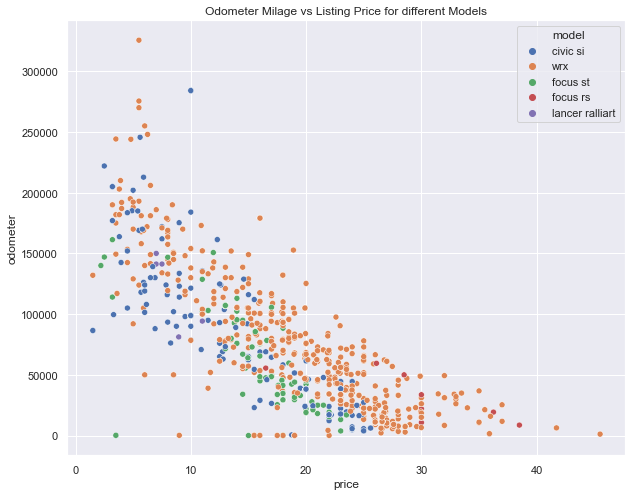

In [580]:
fig = plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='price', y='odometer', hue='model', data=df_ml)
ax.set_title('Odometer Milage vs Listing Price for different Models')

In [581]:
print(f"Unique conditions: {df_ml.condition.unique()}")
print(f"Unique makes: {df_ml.make.unique()}")
print(f"Unique model: {df_ml.model.unique()}")
print(f"Unique title: {df_ml.title.unique()}")
print(f"Unique region: {df_ml.region.unique()}")

Unique conditions: ['good' 'excellent' 'like new' 'fair' 'salvage' 'new']
Unique makes: ['honda' 'subaru' 'ford' 'mitsubishi']
Unique model: ['civic si' 'wrx' 'focus st' 'focus rs' 'lancer ralliart']
Unique title: ['clean' 'lien' 'salvage' 'rebuilt']
Unique region: ['Southeast' 'Far West' 'Southwest' 'Rocky Mountain' 'New England'
 'Mideast' 'Great Lakes' 'Plains']


Okay, the dataset looks to be in decent shape for our use case. Let's also define a vector with my car's information in the same format so that we can use it.

In [582]:
my_wrx = np.array([lp_kbb, 'subaru', 'wrx', 'good', 111000.0, 'clean', 'blue', 8, 'Rocky Mountain']).reshape(1, 9)
my_wrx.dtype

dtype('<U32')

Now let's move on to some ML regression!
### Single Parameter Regression ###

As a first pass, let's try using a single parameter regression using the multi-layer perceptron regressor provided in scikit learn (`MLPRegressor`). Like in our simple data exploration approach, we'll use the odometer reading as our predictor, and for this case, we'll use wrx models only. First we'll need to split the dataset into train and test sets, then we should scale the odometer reading for better input.


In [583]:
def spreg_prep(df, mycar):
    # grab only the columns we need (odometer, price)
    dataset = df[['price', 'odometer']].values
    # Split into input and output variables
    # Scale the odometer reading from 0 - 500k
    X = dataset[:, 1] / 5e5
    y = dataset[:, 0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    X_train = X_train.reshape((len(X_train), 1))
    X_test = X_test.reshape((len(X_test), 1))
    X_eval = mycar[:, 4].astype('float64') / 5e5
    X_eval = X_eval.reshape((1, 1))
    return X_train, X_test, X_eval, y_train, y_test

#     enc = StandardScaler()
#     enc.fit(X_train)
#     X_trn_enc = enc.transform(X_train)
#     X_tst_enc = enc.transform(X_test)
#     X_mycar_enc = enc.transform(mycar[:, 4].reshape((1, 1)))
#     return X_trn_enc, X_tst_enc, X_mycar_enc, y_train, y_test

In [584]:
X_trn, X_tst, X_evl, y_trn, y_tst = spreg_prep(df_ml[df_ml.model == 'wrx'], my_wrx)
print(f"X_trn.shape: {X_trn.shape}, {X_trn.dtype}")
print(f"y_trn.shape: {y_trn.shape}, {y_trn.dtype}")
print(f"X_tst.shape: {X_tst.shape}, {X_tst.dtype}")
print(f"y_tst.shape: {y_tst.shape}, {y_tst.dtype}")
print(f"X_evl.shape: {X_evl.shape}, {X_evl.dtype}")
print(f"X_evl: {X_evl}")

X_trn.shape: (427, 1), float64
y_trn.shape: (427,), float64
X_tst.shape: (211, 1), float64
y_tst.shape: (211,), float64
X_evl.shape: (1, 1), float64
X_evl: [[0.222]]


Now that we've massaged the data into a reasonable input, we can use the `MLPRegressor` provided in scikit learn to estimate the list price for my WRX based solely on the odometer reading. For the moment, let's stick with all the default parameters, with the possible exception of `max_iter` if it doesn't converge.

In [585]:
sp_regr = MLPRegressor(max_iter=5000).fit(X_trn, y_trn)

Current loss: 7.63188336513183
Best loss: 7.629253577379731
Score on Train: 0.7073402336528265
Score on Test: 0.6850593481923448
Predicted List Price for my WRX: 15.362736876523702
Estimated List Price above:      15.565828749119703


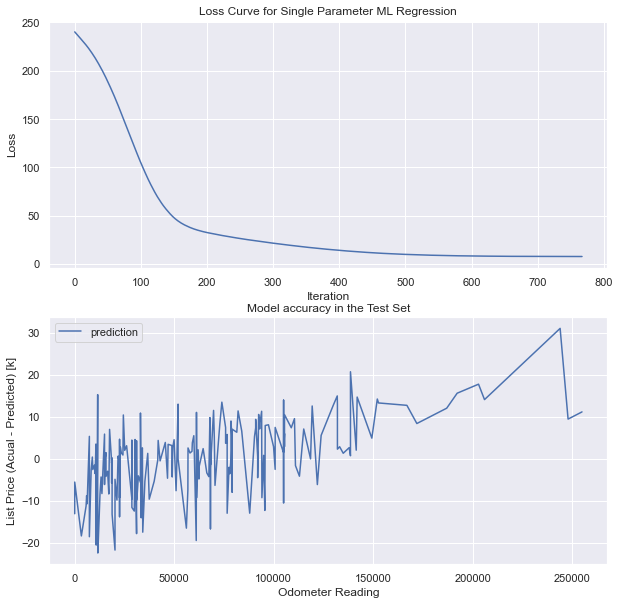

In [586]:
print(f"Current loss: {sp_regr.loss_}")
print(f"Best loss: {sp_regr.best_loss_}")
print(f"Score on Train: {sp_regr.score(X_trn, y_trn)}")
print(f"Score on Test: {sp_regr.score(X_tst, y_tst)}")
score_spreg = sp_regr.score(X_tst, y_tst)

lp_spreg = sp_regr.predict(X_evl)[0]
print(f"Predicted List Price for my WRX: {lp_spreg}")
print(f"Estimated List Price above:      {lp_simple}")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
ax[0].plot(np.arange(0, sp_regr.n_iter_), sp_regr.loss_curve_)
ax[0].set_title('Loss Curve for Single Parameter ML Regression')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')

X_tst.sort(axis=0)
X_tst = X_tst.reshape((len(X_tst), 1))
# ax[1].plot(X_tst, y_tst, marker='o', lw=0, label='test data')
ax[1].plot(X_tst*5e5, y_tst - sp_regr.predict(X_tst), label='prediction')
# ax[1].plot(X_evl, sp_regr.predict(X_evl), marker='o', color='red', label='My WRX')
ax[1].set_title('Model accuracy in the Test Set')
ax[1].set_xlabel('Odometer Reading')
ax[1].set_ylabel('List Price (Acual - Predicted) [k]')
ax[1].legend()

I would expect this to give a value reasonably close to my simple data exploration approach above. Indeed, it's close but a little lower than our initial estimate. This could easily be due to the fact that the initial esimate was also filtered on age and condition, where this is using the odometer reading only.

### Two-Parameter ML Regression using WRX Listings ###

Now let's try including more parameters, but sticking with WRX listings only.

In [587]:
def dpreg_prep(df, mycar):
    # grab only the columns we need (odometer, price)
    dataset = df[['price', 'odometer', 'age']].values
    # Split into input and output variables
    X = dataset[:, 1:]
    y = dataset[:, 0]
    X[:, 0] /= 5e5
    X[:, 1] /= 20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    X_eval = mycar[:, [4, 7]].reshape((1, 2)).astype('float64')
    X_eval[:, 0] /= 5e5
    X_eval[:, 1] /= 20
    return X_train, X_test, X_eval, y_train, y_test
    
#     enc = MinMaxScaler()
#     enc.fit(X_train)
#     X_trn_enc = enc.transform(X_train)
#     X_tst_enc = enc.transform(X_test)
#     X_mycar_enc = enc.transform(mycar[:, [4, 7]].reshape((1, 2)))
#     return X_trn_enc, X_tst_enc, X_mycar_enc, y_train, y_test

In [588]:
X_trn, X_tst, X_evl, y_trn, y_tst = dpreg_prep(df_ml[df_ml.model == 'wrx'], my_wrx)
print(f"X_trn.shape: {X_trn.shape}, {X_trn.dtype}")
print(f"y_trn.shape: {y_trn.shape}, {y_trn.dtype}")
print(f"X_tst.shape: {X_tst.shape}, {X_tst.dtype}")
print(f"y_tst.shape: {y_tst.shape}, {y_tst.dtype}")
print(f"X_evl.shape: {X_evl.shape}, {X_evl.dtype}")

X_trn.shape: (427, 2), float64
y_trn.shape: (427,), float64
X_tst.shape: (211, 2), float64
y_tst.shape: (211,), float64
X_evl.shape: (1, 2), float64


In [589]:
dp_regr = MLPRegressor(max_iter=1000).fit(X_trn, y_trn)

Current loss: 4.7835213160907815
Best loss: 4.783502628773343
Score on Train: 0.8016615761568519
Score on Test: 0.792067970750512
Predicted List Price for my WRX: 16.440678962440384
Estimated List Price above:      15.565828749119703


Text(0, 0.5, 'List Price (Actual - Predicted) [k]')

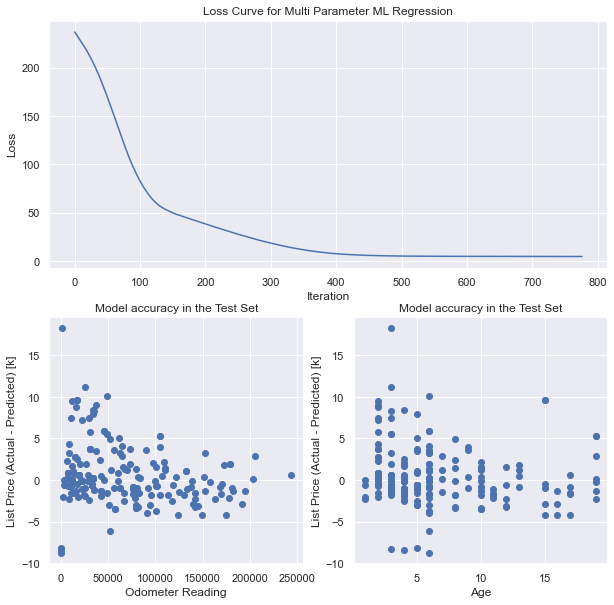

In [590]:
print(f"Current loss: {dp_regr.loss_}")
print(f"Best loss: {dp_regr.best_loss_}")
print(f"Score on Train: {dp_regr.score(X_trn, y_trn)}")
print(f"Score on Test: {dp_regr.score(X_tst, y_tst)}")
score_dpreg = dp_regr.score(X_tst, y_tst)

lp_dpreg = dp_regr.predict(X_evl)[0]
print(f"Predicted List Price for my WRX: {lp_dpreg}")
print(f"Estimated List Price above:      {lp_simple}")

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(nrows=2, ncols=2)

ax = [fig.add_subplot(gs[:-1, :]), 
      fig.add_subplot(gs[-1, 0]),
      fig.add_subplot(gs[-1, 1])]
ax[0].plot(np.arange(0, dp_regr.n_iter_), dp_regr.loss_curve_)
ax[0].set_title('Loss Curve for Multi Parameter ML Regression')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')

ax[1].plot(X_tst[:, 0]*5e5, y_tst - dp_regr.predict(X_tst), marker='o', lw=0)
ax[1].set_title('Model accuracy in the Test Set')
ax[1].set_xlabel('Odometer Reading')
ax[1].set_ylabel('List Price (Actual - Predicted) [k]')

ax[2].plot(X_tst[:, 1]*20, y_tst - dp_regr.predict(X_tst), marker='o', lw=0)
ax[2].set_title('Model accuracy in the Test Set')
ax[2].set_xlabel('Age')
ax[2].set_ylabel('List Price (Actual - Predicted) [k]')

In [591]:
def mpreg_prep(df, mycar):
    # convert dataframe to numpy array
    dataset = df.values
    # split into input (X) and output (y) variables
    X = dataset[:, 1:]
    y = dataset[:, 0]
    # split into train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    X_eval = mycar[:, 1:].reshape((1, X.shape[1]))
    
    # Column mapping reminder:
    #  0 - make (One Hot)
    #  1 - model (One Hot)
    #  2 - condition (Ordinal)
    #  3 - odometer (float)
    #  4 - title (Ordinal)
    #  5 - color (One Hot)
    #  6 - age (int)
    #  7 - region (One Hot)
    ohe_enc = OneHotEncoder()
    ohe_enc.fit(X_train[:, [0, 1, 5, 7]])
        
    ord_enc = OneHotEncoder(categories=[['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],
                                        ['salvage', 'rebuilt', 'lien', 'clean']])
    ord_enc.fit(X_train[:, [2, 4]])

    scl_enc = MinMaxScaler()
    scl_enc.fit(X_train[:, [3, 6]])
    
    X_trn = np.hstack((ohe_enc.transform(X_train[:, [0, 1, 5, 7]]).toarray(),
                       ord_enc.transform(X_train[:, [2, 4]]).toarray(),
                       scl_enc.transform(X_train[:, [3, 6]])))
    X_tst = np.hstack((ohe_enc.transform(X_test[:, [0, 1, 5, 7]]).toarray(),
                       ord_enc.transform(X_test[:, [2, 4]]).toarray(),
                       scl_enc.transform(X_test[:, [3, 6]])))
    X_evl = np.hstack((ohe_enc.transform(X_eval[:, [0, 1, 5, 7]]).toarray(),
                       ord_enc.transform(X_eval[:, [2, 4]]).toarray(),
                       scl_enc.transform(X_eval[:, [3, 6]])))
    return X_trn, X_tst, X_evl, y_train, y_test

In [592]:
X_trn, X_tst, X_evl, y_trn, y_tst = mpreg_prep(df_ml[df_ml.model == 'wrx'], my_wrx)
print(f"X_trn.shape: {X_trn.shape}, {X_trn.dtype}")
print(f"y_trn.shape: {y_trn.shape}, {y_trn.dtype}")
print(f"X_tst.shape: {X_tst.shape}, {X_tst.dtype}")
print(f"y_tst.shape: {y_tst.shape}, {y_tst.dtype}")
print(f"X_evl.shape: {X_evl.shape}, {X_evl.dtype}")

X_trn.shape: (427, 30), float64
y_trn.shape: (427,), object
X_tst.shape: (211, 30), float64
y_tst.shape: (211,), object
X_evl.shape: (1, 30), float64


In [593]:
mp_regr = MLPRegressor(max_iter=5000).fit(X_trn, y_trn)

Current loss: 3.2494866170215286
Best loss: 3.2420740068887293
Score on Train: 0.8780162263072712
Score on Test: 0.8379107440950333
Predicted List Price for my WRX: 11.285264505966266
Estimated List Price above:      15.565828749119703


Text(0, 0.5, 'Loss')

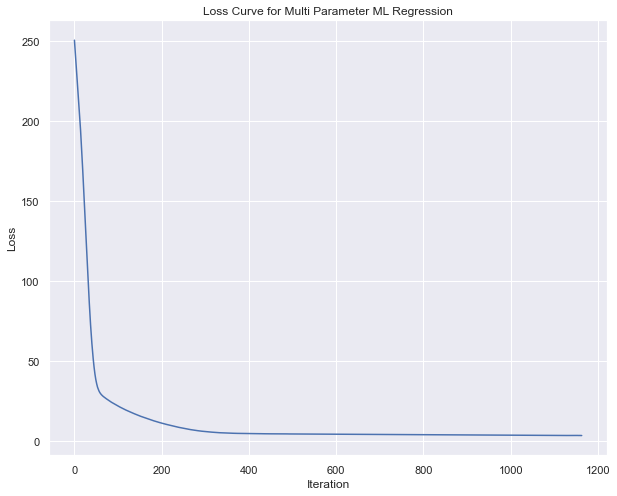

In [594]:
print(f"Current loss: {mp_regr.loss_}")
print(f"Best loss: {mp_regr.best_loss_}")
print(f"Score on Train: {mp_regr.score(X_trn, y_trn)}")
print(f"Score on Test: {mp_regr.score(X_tst, y_tst)}")
score_mpreg = mp_regr.score(X_tst, y_tst)

lp_mpreg = mp_regr.predict(X_evl)[0]
print(f"Predicted List Price for my WRX: {lp_mpreg}")
print(f"Estimated List Price above:      {lp_simple}")

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(np.arange(0, mp_regr.n_iter_), mp_regr.loss_curve_)
ax.set_title('Loss Curve for Multi Parameter ML Regression')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')


In [607]:
df_results = pd.DataFrame(columns=['Method', 'score', 'List Price'])
df_results = df_results.append({'Method': 'KBB', 'score': np.nan, 'List Price': lp_kbb},
                              ignore_index=True)
df_results = df_results.append({'Method': 'Similar Listings', 'score': np.nan, 'List Price': lp_simple}, 
                               ignore_index=True)
df_results = df_results.append({'Method': 'MLPRegressor - WRX - Odomenter', 
                                'score': score_spreg, 'List Price': lp_spreg}, ignore_index=True)
df_results = df_results.append({'Method': 'MLPRegressor - WRX - Odometer/Age',
                                'score': score_dpreg, 'List Price': lp_dpreg}, ignore_index=True)
df_results = df_results.append({'Method': 'MLPRegressor - WRX', 'score': score_mpreg, 'List Price': lp_mpreg}, 
                                ignore_index=True)
df_results

,Method,score,List Price
0,KBB,NaN,11.932000
1,Similar Listings,NaN,15.565829
2,MLPRegressor - WRX - Odomenter,0.685059,15.362737
3,MLPRegressor - WRX - Odometer/Age,0.792068,16.440679
4,MLPRegressor - WRX,0.837911,11.285265
